https://www.kaggle.com/c/whats-cooking/

In [120]:
import json

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
import torch
from torch.nn import functional as F

sns.set()

In [2]:
%%time
filename = "./whats-cooking/train.json"
with open(filename) as f:
    data_json = json.load(f)

CPU times: user 131 ms, sys: 7.2 ms, total: 139 ms
Wall time: 149 ms


In [3]:
data = pd.DataFrame(data_json)
data.shape

(39774, 3)

In [4]:
data

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


In [5]:
cuisine_counts = data['cuisine'].value_counts()
cuisines = cuisine_counts.index
print(len(cuisines))
cuisine_counts

20


cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: count, dtype: int64

In [6]:
ingredient_counts = pd.Series(
    [ingredient.lower() for ingredient_list in data['ingredients'] for ingredient in ingredient_list]) \
    .value_counts()
print(len(ingredient_counts))
ingredient_counts

6703


salt                                   18049
onions                                  7972
olive oil                               7972
water                                   7457
garlic                                  7380
                                       ...  
low sodium fat free vegetable broth        1
garbonzo bean                              1
whole garam masala                         1
rose hip tea bags                          1
crushed cheese crackers                    1
Name: count, Length: 6703, dtype: int64

In [7]:
word_counts = pd.DataFrame(
    [(word.lower(), cnt) for ingredient, cnt in ingredient_counts.items() for word in ingredient.split(' ')],
    columns=['word', 'count']).groupby('word')['count'].sum().sort_values(ascending=False)
word_counts

word
pepper              25686
salt                24426
oil                 23323
garlic              18921
ground              18256
                    ...  
neapolitan              1
chocolatecovered        1
psyllium                1
knoflook                1
pane                    1
Name: count, Length: 3188, dtype: int64

In [8]:
n_ingredients = 500
ingredients = ingredient_counts.head(n_ingredients).index

In [9]:
ingredient_counts.head(n_ingredients)

salt                       18049
onions                      7972
olive oil                   7972
water                       7457
garlic                      7380
                           ...  
boneless chicken breast      146
cooked white rice            145
crème fraîche                145
pecans                       144
panko breadcrumbs            144
Name: count, Length: 500, dtype: int64

In [10]:
ingredients
data['top_ingredients'] = data['ingredients'].map(lambda x: sorted(set(x).intersection(ingredients)))
data['n_top_ingredients'] = data['top_ingredients'].map(len)
data['n_top_ingredients'].max()

53

In [11]:
data.head()

,id,cuisine,ingredients,top_ingredients,n_top_ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","[black olives, feta cheese crumbles, garbanzo ...",8
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","[eggs, ground black pepper, ground pepper, mil...",10
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[butter, cooking oil, eggs, garlic powder, gre...",10
3,22213,indian,"[water, vegetable oil, wheat, salt]","[salt, vegetable oil, water]",3
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","[bay leaf, black pepper, boneless chicken skin...",16


<Axes: >

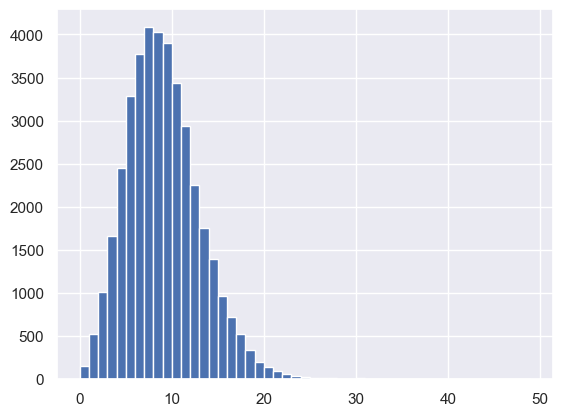

In [12]:
data['n_top_ingredients'].hist(bins=np.arange(50))

In [13]:
(data['n_top_ingredients'] <= 15).mean()

0.945391461758938

#### create dataset to train model

In [14]:
len(data)

39774

In [15]:
ingredients
ingredient_to_i = dict(zip(ingredients, range(len(ingredients))))
cuisine_to_i = dict(zip(cuisines, range(len(cuisines))))

In [16]:
data['top_ingredients_i'] = data['top_ingredients'].map(
    lambda x: sorted(ingredient_to_i[y] for y in x))
data['cuisine_i'] = data['cuisine'].map(cuisine_to_i)

In [17]:
data.head()

,id,cuisine,ingredients,top_ingredients,n_top_ingredients,top_ingredients_i,cuisine_i
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","[black olives, feta cheese crumbles, garbanzo ...",8,"[4, 10, 27, 217, 297, 341, 342, 492]",9
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","[eggs, ground black pepper, ground pepper, mil...",10,"[0, 8, 11, 12, 16, 23, 202, 216, 239, 482]",2
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[butter, cooking oil, eggs, garlic powder, gre...",10,"[0, 7, 10, 12, 13, 48, 64, 106, 108, 154]",15
3,22213,indian,"[water, vegetable oil, wheat, salt]","[salt, vegetable oil, water]",3,"[0, 3, 11]",3
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","[bay leaf, black pepper, boneless chicken skin...",16,"[0, 1, 3, 7, 20, 22, 23, 24, 25, 43, 47, 50, 8...",3


In [18]:
n_context = 10  # sample some ingredients from full list (pad with EMPTY if less so)
n_samples = 5  # do not sample more than 10 times from same recipe

In [19]:
%%time
np.random.seed(123)
# create rows with combinations from the recipes
features, labels = [], []
for _, recipe in data.iterrows():
    if recipe['top_ingredients']:
        draws = np.random.choice(recipe['top_ingredients_i'], (n_samples, n_context), replace=True)
        labels.extend(n_samples * [recipe['cuisine_i']])
        for draw in draws:
            features.append(draw)
features, labels = np.array(features), np.array(labels)            

CPU times: user 913 ms, sys: 12.4 ms, total: 925 ms
Wall time: 924 ms


In [20]:
features.shape

(198130, 10)

In [21]:
features, labels

(array([[342, 341, 342, ...,  10, 217,  27],
        [217,  10, 342, ..., 492,  10,   4],
        [342,   4, 492, ..., 297,   4,   4],
        ...,
        [  4,  36,  35, ...,  35,  65,  35],
        [ 73, 102,  36, ..., 266,  34, 344],
        [344, 344,  73, ..., 266, 266,   4]]),
 array([9, 9, 9, ..., 1, 1, 1]))

#### create model

In [294]:
dtype = torch.float
device = "cpu" 
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
torch.set_default_device(device)
print(f"Using {device} device")

Using mps device


In [322]:
X_t, y_t = torch.Tensor(features).int(), torch.Tensor(labels).int()
X_t, y_t = X_t.to(device), y_t.to(device)

np.random.seed(123)
idx = np.random.random(len(X_t)) < .8
X_train, X_test, y_train, y_test = X_t[idx], X_t[~idx], y_t[idx], y_t[~idx]

In [323]:
g = torch.Generator(device=device).manual_seed(123) # for reproducibility
ingredient_emb_dim = 2
ingredient_emb = torch.randn((n_ingredients, ingredient_emb_dim), generator=g)
ingredient_emb[:5]

tensor([[ 2.2035,  0.4599],
        [ 0.5828, -0.5727],
        [-1.7389, -0.1414],
        [-1.7129, -0.3694],
        [ 0.5239,  0.4470]], device='mps:0')

In [442]:
input_layer_dim = ingredient_emb_dim * n_context
n_hidden_neurons = 100  # or 100?
hidden_layer_dim = ingredient_emb_dim * n_hidden_neurons
n_output_dim = len(cuisines)

g = torch.Generator(device=device).manual_seed(123) # for reproducibility
C = torch.randn((n_ingredients, ingredient_emb_dim), generator=g, dtype=dtype, requires_grad=True)  # ingr. emb.
W1 = torch.randn((input_layer_dim, hidden_layer_dim), generator=g, dtype=dtype, requires_grad=True)
b1 = torch.randn(hidden_layer_dim, generator=g, dtype=dtype, requires_grad=True)
W2 = torch.randn((hidden_layer_dim, n_output_dim), generator=g, dtype=dtype, requires_grad=True)
b2 = torch.randn(n_output_dim, generator=g, dtype=dtype, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [443]:
sum(p.nelement() for p in parameters) # number of parameters in total

9220

In [451]:
%%time
# n_epochs = int(1e3)  # passes through full data set
batch_size = len(X_train) // 100
n_steps = 1 + int(2e3)  # n_epochs * len(X_t) // batch_size
n_prints = 10
learning_rates = 10 ** np.linspace(0, -3, n_steps)
# learning_rates = 1 * np.ones(n_steps)
# learning_rate = 1
stats = []

for i in range(n_steps):
  
    # forward pass
    ix = torch.randint(0, X_train.shape[0], (batch_size,))  # minibatch construct
    emb = C[X_train[ix]]  # (few rows, few tokens, few-dim embeddings)    
    h = torch.tanh(emb.view(-1, input_layer_dim) @ W1 + b1)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, y_train[ix]) + (C ** 2).mean()  # L2 regularization
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    learning_rate = learning_rates[i]
    for p in parameters:
        p.data -= learning_rate * p.grad
        
    # track stats
    stats.append({
        'i': i,
        'tr log loss': loss.log10().item(),
    })
        

    if i % (n_steps // n_prints) == 0:
        # extra evals
        aucs, accs = [], []
        for cuisine_i in range(len(cuisines)):
            pos = (y_train[ix] == cuisine_i).cpu().data
            auc = roc_auc_score(pos, logits[:, cuisine_i].cpu().data) if pos.any() and not pos.all() else None
            acc = (pos == (cuisine_i == logits.argmax(axis=1)).cpu()).float().mean().item()
            stats[-1]['%s tr auc' % cuisines[cuisine_i]] = auc
            stats[-1]['%s tr acc' % cuisines[cuisine_i]] = acc
            aucs.append((auc, pos.sum()))
            accs.append((acc, pos.sum()))
        auc = sum(auc * n for auc, n in aucs) / len(ix)
        acc = sum(acc * n for acc, n in accs) / len(ix)
        stats[-1]['avg tr auc'] = auc.item()
        stats[-1]['avg tr acc'] = acc.item()
        acc = (y_train[ix] == logits.argmax(axis=1)).cpu().float().mean().item()
        stats[-1]['multi-class tr acc'] = acc
                    
#         # test
#         ix = torch.randint(0, X_t.shape[0], (batch_size,))  # minibatch construct
#         emb = C[X_train[ix]]  # (few rows, few tokens, few-dim embeddings)    
#         h = torch.tanh(emb.view(-1, input_layer_dim) @ W1 + b1)
#         logits = h @ W2 + b2 # (32, 27)
#         loss = F.cross_entropy(logits, y_train[ix]) + (C ** 2).mean()  # L2 regularization

        print("%6s  loss %7.4f  auc %.4f  acc %.4f" % (i, loss.data, auc, acc))

stats = pd.DataFrame(stats).set_index('i')    

     0  loss  1.8337  auc 0.8088  acc 0.4968
   200  loss  1.8655  auc 0.8094  acc 0.4590
   400  loss  1.7067  auc 0.8178  acc 0.5183
   600  loss  1.6559  auc 0.8226  acc 0.5158
   800  loss  1.6134  auc 0.8295  acc 0.5328
  1000  loss  1.7283  auc 0.8186  acc 0.4975
  1200  loss  1.6598  auc 0.8213  acc 0.5095
  1400  loss  1.6272  auc 0.8246  acc 0.5253
  1600  loss  1.6038  auc 0.8252  acc 0.5189
  1800  loss  1.6505  auc 0.8229  acc 0.5114
  2000  loss  1.6000  auc 0.8297  acc 0.5372
CPU times: user 4.32 s, sys: 642 ms, total: 4.96 s
Wall time: 7.26 s


In [452]:
stats.dropna(how='any')

,tr log loss,italian tr auc,italian tr acc,mexican tr auc,mexican tr acc,southern_us tr auc,southern_us tr acc,indian tr auc,indian tr acc,chinese tr auc,...,irish tr acc,jamaican tr auc,jamaican tr acc,russian tr auc,russian tr acc,brazilian tr auc,brazilian tr acc,avg tr auc,avg tr acc,multi-class tr acc
i,,,,,,,,,,,,,,,,,,,,,
0,0.263326,0.881203,0.831439,0.879904,0.899621,0.727560,0.810606,0.841575,0.939394,0.913325,...,0.986111,0.697586,0.987374,0.615455,0.986742,0.624329,0.986111,0.808791,0.906083,0.496843
200,0.270799,0.872985,0.861111,0.881527,0.916035,0.779231,0.712753,0.869110,0.945707,0.884794,...,0.982323,0.616829,0.989268,0.645736,0.988636,0.494661,0.986742,0.809368,0.905640,0.458965
400,0.232157,0.879360,0.815657,0.908101,0.909722,0.729203,0.852904,0.867447,0.948864,0.888519,...,0.980429,0.614143,0.986742,0.639226,0.987374,0.599169,0.987374,0.817762,0.912075,0.518308
600,0.219046,0.887207,0.837753,0.897302,0.907828,0.758170,0.820707,0.863067,0.947601,0.908086,...,0.984217,0.678392,0.984217,0.680291,0.987374,0.624486,0.988636,0.822553,0.908855,0.515783
800,0.207737,0.900931,0.824495,0.893370,0.919823,0.793370,0.857955,0.863453,0.957071,0.923353,...,0.984848,0.579655,0.986742,0.638676,0.988636,0.658081,0.988636,0.829510,0.913736,0.532828
1000,0.237631,0.885505,0.792298,0.875684,0.904672,0.768979,0.852273,0.867356,0.954545,0.906260,...,0.983586,0.673961,0.986111,0.712025,0.990530,0.652547,0.988636,0.818616,0.904505,0.497475
1200,0.220061,0.886339,0.825126,0.882936,0.910354,0.769007,0.830808,0.846262,0.944444,0.878511,...,0.978535,0.624237,0.988636,0.642019,0.986742,0.581704,0.989268,0.821337,0.909515,0.509470
1400,0.211442,0.884818,0.823864,0.869194,0.909722,0.790037,0.841540,0.885554,0.955177,0.904959,...,0.988636,0.682899,0.988005,0.564804,0.991162,0.676818,0.984217,0.824573,0.910465,0.525253
1600,0.205149,0.907019,0.832071,0.888811,0.902778,0.763211,0.845960,0.860910,0.953283,0.869218,...,0.984848,0.678853,0.986742,0.571005,0.989268,0.691216,0.988636,0.825209,0.909450,0.518939


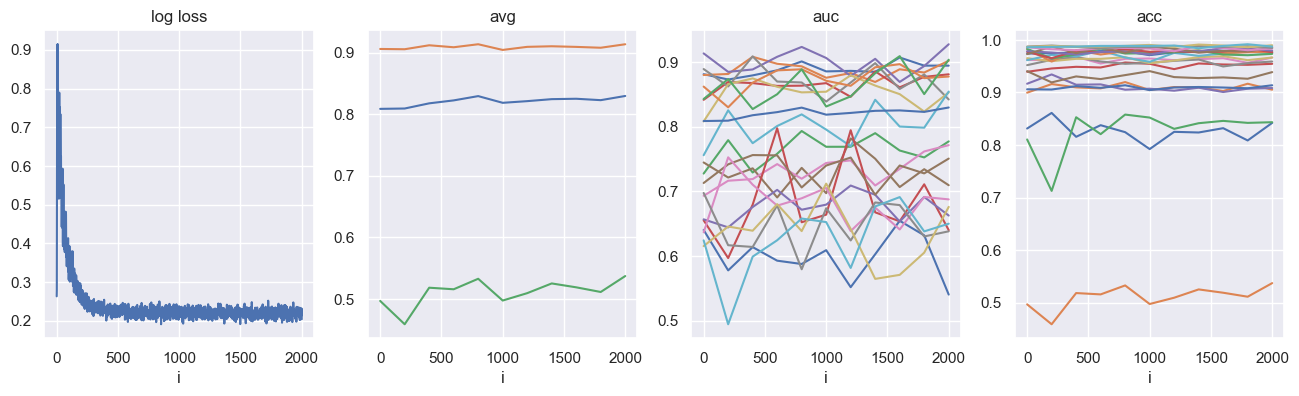

In [453]:
_, axs = plt.subplots(1, 4, figsize=(16, 4))
metrics = ['log loss', 'avg', 'auc', 'acc']
for ax, metric in zip(axs, metrics):
    cols = [col for col in stats.columns if metric in col]
    if metric == 'avg':
        cols += [col for col in stats.columns if 'multi-class' in col]
    stats[cols].dropna(how='any').plot(ax=ax, legend=False)
    ax.set_title(metric)
    ax.set_alpha(0)

In [454]:
metric = 'avg'
cols = [col for col in stats.columns if metric in col]
if metric == 'avg':
    cols += [col for col in stats.columns if 'multi-class' in col]
stats[cols].dropna(how='any').plot(ax=ax, legend=False)
ax.set_title(metric)
ax.set_alpha(0)

stats[cols].dropna(how='any')

,avg tr auc,avg tr acc,multi-class tr acc
i,,,
0,0.808791,0.906083,0.496843
200,0.809368,0.905640,0.458965
400,0.817762,0.912075,0.518308
600,0.822553,0.908855,0.515783
800,0.829510,0.913736,0.532828
1000,0.818616,0.904505,0.497475
1200,0.821337,0.909515,0.509470
1400,0.824573,0.910465,0.525253
1600,0.825209,0.909450,0.518939


In [455]:
# stats.dropna(how='any')

<Axes: >

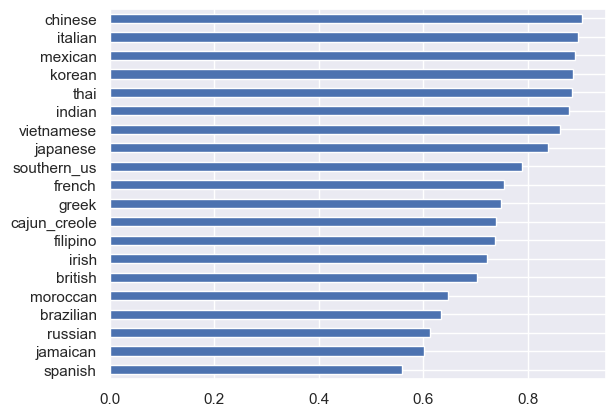

In [456]:
auc_cols = [col for col in stats_sm.columns if 'auc' in col]
s = stats_sm[auc_cols].tail().mean().sort_values()  # ascending=False)
s.index = s.index.str.replace(' tr auc', '')
s.plot(kind='barh')

<Axes: >

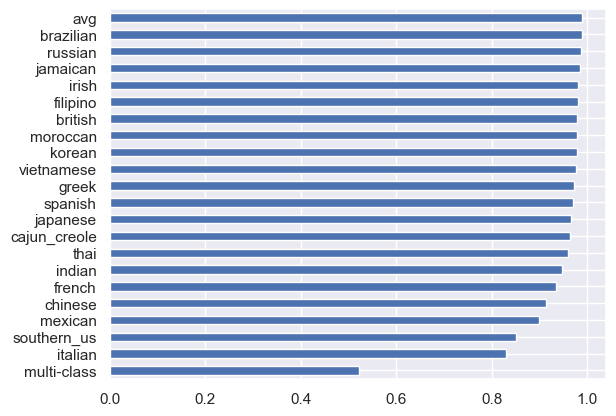

In [457]:
acc_cols = [col for col in stats_sm.columns if 'acc' in col]
s = stats_sm[acc_cols].tail().mean().sort_values()  # ascending=False)
s.index = s.index.str.replace(' tr acc', '')
s.plot(kind='barh')

<Axes: >

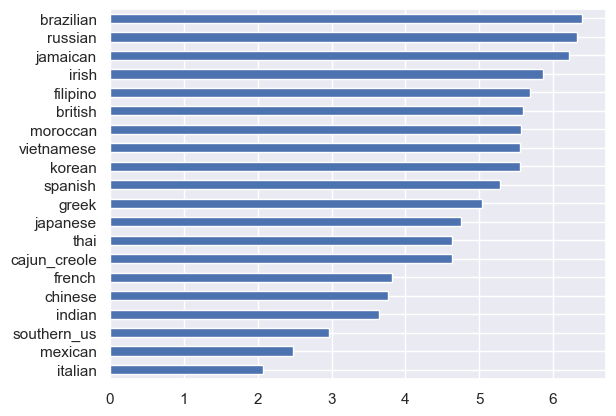

In [458]:
acc_cols = [col for col in stats_sm.columns if 'acc' in col]
s = stats_sm[acc_cols].tail().mean().sort_values()  # ascending=False)
s.index = s.index.str.replace(' tr acc', '')
prev = (cuisine_counts / cuisine_counts.sum())
s = np.log2(s / prev).sort_values().dropna()
s.plot(kind='barh')

### embedding analysis

In [459]:
ingr_emb = pd.DataFrame(C.cpu().data, index=ingredients)
ingr_emb['counts'] = ingredient_counts
ingr_emb['r'] = np.sqrt(np.square(ingr_emb[[0, 1]]).sum(axis=1))
ingr_emb.head()

,0,1,counts,r
salt,-0.016912,-0.005827,18049,0.017887
onions,-0.000175,-0.025187,7972,0.025188
olive oil,-0.075901,0.077765,7972,0.108666
water,-0.032748,-0.025631,7457,0.041586
garlic,-0.034295,-0.024409,7380,0.042095


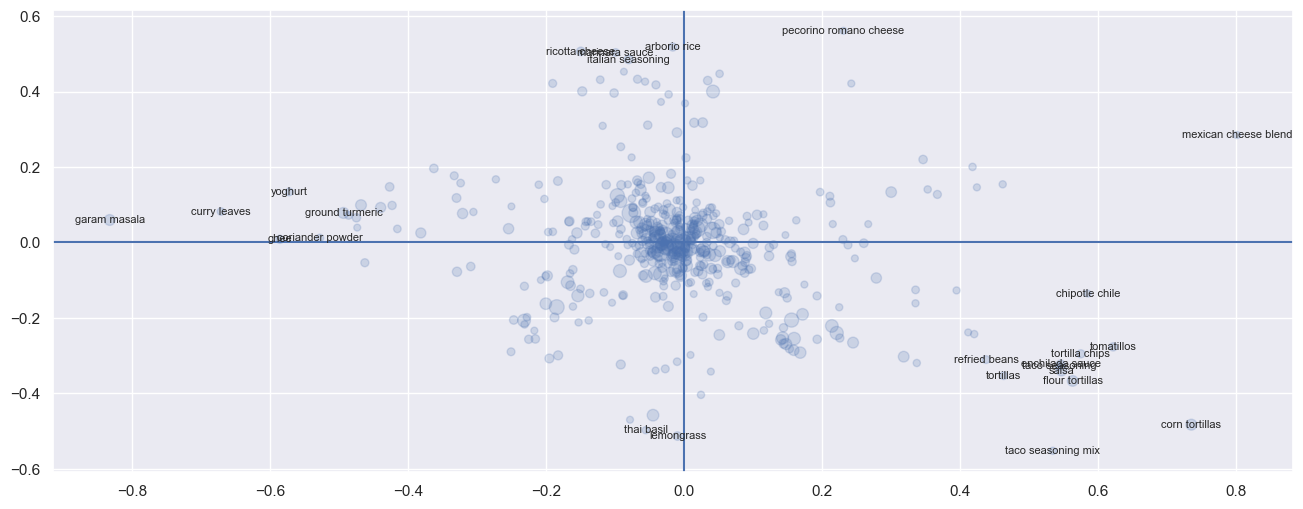

In [460]:
_, ax = plt.subplots(figsize=(16, 6))
ax.scatter(ingr_emb[0], ingr_emb[1], s=2 * np.sqrt(ingr_emb['counts']), alpha=.2)
ax.axhline(), ax.axvline()
idx = ingr_emb['r'] > ingr_emb['r'].quantile(.95)
for label, coord in ingr_emb[idx].iterrows():
    ax.text(coord[0], coord[1], label.replace(' ', ' '), ha='center', va='center', fontsize=8)

In [461]:
coord_norm = ingr_emb[[0, 1]].values / ingr_emb['r'].values.reshape(-1, 1)
ingr_emb['x'] = coord_norm[:, 0]
ingr_emb['y'] = coord_norm[:, 1]

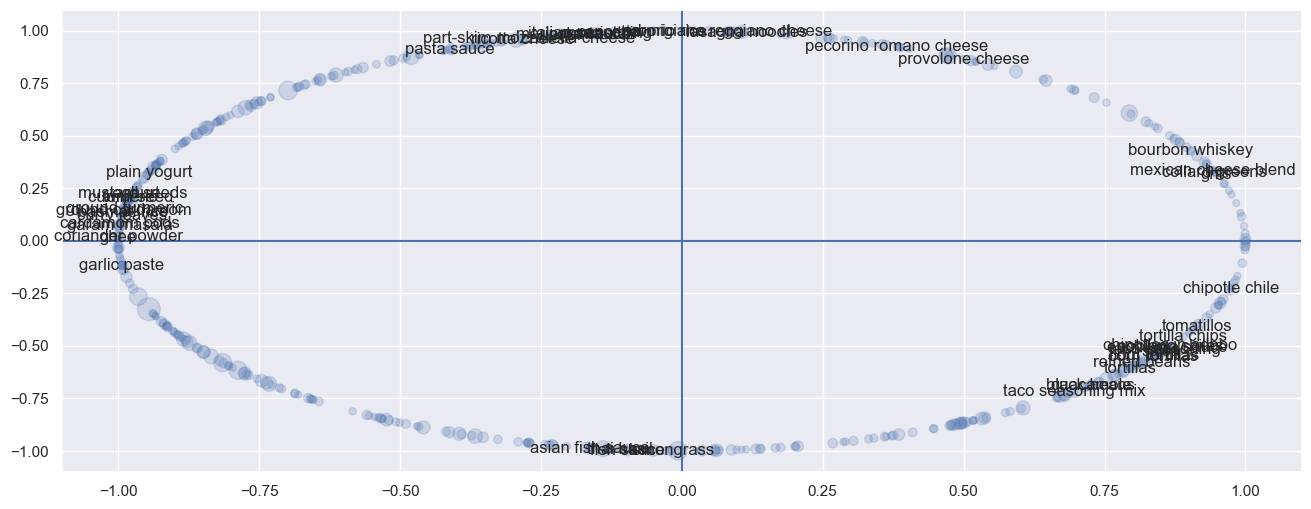

In [462]:
_, ax = plt.subplots(figsize=(16, 6))
ax.scatter(ingr_emb['x'], ingr_emb['y'], s=2 * np.sqrt(ingr_emb['counts']), alpha=.2)
ax.axhline(), ax.axvline()
idx = ingr_emb['r'] > ingr_emb['r'].quantile(.9)
for label, coord in ingr_emb[idx].iterrows():
    ax.text(coord['x'], coord['y'], label.replace(' ', ' '), ha='center', va='center', fontsize=12)

In [463]:
ingr

NameError: name 'ingr' is not defined

In [464]:
M = pd.DataFrame(coord_norm.dot(coord_norm.T), index=ingredients, columns=ingredients)
order = M.mean().sort_values().index
M = M.loc[order, order]

<Axes: >

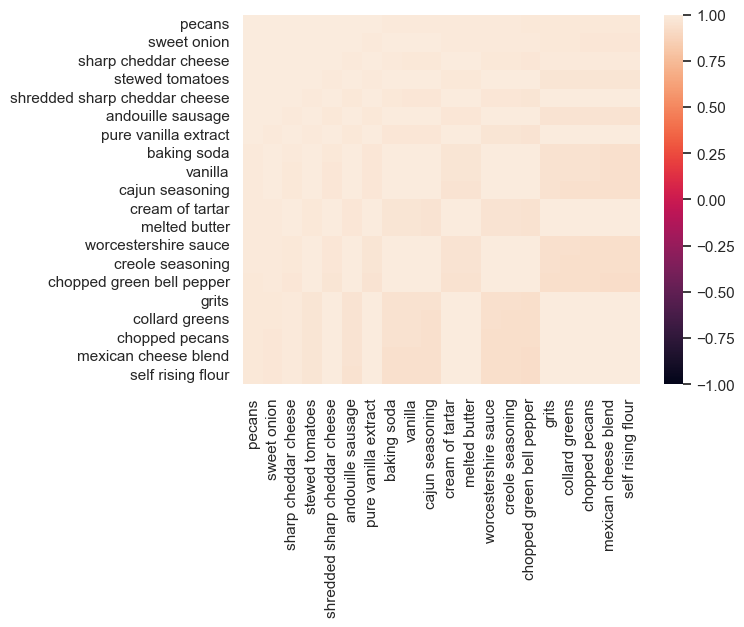

In [465]:
sns.heatmap(M.iloc[:20, :20], vmin=-1, vmax=1)

<Axes: >

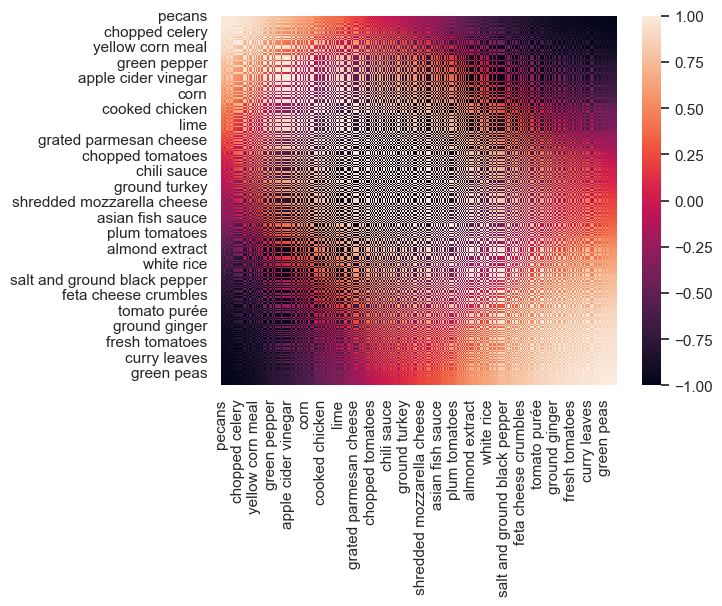

In [466]:
sns.heatmap(M)